In [ ]:
from google.colab import drive
import zipfile  
drive.mount('/gdrive')
dataset_path = "/gdrive/My Drive/cs446/FA20_CS446_Project_Data.zip"  # Replace with your dataset path
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
dataset_path = "FA20_CS446_Project_Data/data_pub.zip"
zfile = zipfile.ZipFile(dataset_path)
zfile.extractall()

In [ ]:
# Keras implementation of the paper:
# 3D MRI Brain Tumor Segmentation Using Autoencoder Regularization
# by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)
# Author of this code: Suyog Jadhav (https://github.com/IAmSUyogJadhav)

import keras.backend as K
from keras.losses import mse
from keras.layers import Conv3D, Activation, Add, UpSampling3D, Lambda, Dense
from keras.layers import Input, Reshape, Flatten, Dropout, SpatialDropout3D
from keras.optimizers import Adam
from keras.models import Model
try:
    from group_norm import GroupNormalization
except ImportError:
    import urllib.request
    print('Downloading group_norm.py in the current directory...')
    url = 'https://raw.githubusercontent.com/titu1994/Keras-Group-Normalization/master/group_norm.py'
    urllib.request.urlretrieve(url, "group_norm.py")
    from group_norm import GroupNormalization


def green_block(inp, filters, data_format='channels_first', name=None):
    """
    green_block(inp, filters, name=None)
    ------------------------------------
    Implementation of the special residual block used in the paper. The block
    consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
    units, with a residual connection from the input `inp` to the output. Used
    internally in the model. Can be used independently as well.

    Parameters
    ----------
    `inp`: An keras.layers.layer instance, required
        The keras layer just preceding the green block.
    `filters`: integer, required
        No. of filters to use in the 3D convolutional block. The output
        layer of this green block will have this many no. of channels.
    `data_format`: string, optional
        The format of the input data. Must be either 'chanels_first' or
        'channels_last'. Defaults to `channels_first`, as used in the paper.
    `name`: string, optional
        The name to be given to this green block. Defaults to None, in which
        case, keras uses generated names for the involved layers. If a string
        is provided, the names of individual layers are generated by attaching
        a relevant prefix from [GroupNorm_, Res_, Conv3D_, Relu_, ], followed
        by _1 or _2.

    Returns
    -------
    `out`: A keras.layers.Layer instance
        The output of the green block. Has no. of channels equal to `filters`.
        The size of the rest of the dimensions remains same as in `inp`.
    """
    inp_res = Conv3D(
        filters=filters,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format=data_format,
        name=f'Res_{name}' if name else None)(inp)

    # axis=1 for channels_first data format
    # No. of groups = 8, as given in the paper
    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_1_{name}' if name else None)(inp)
    x = Activation('relu', name=f'Relu_1_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_1_{name}' if name else None)(x)

    x = GroupNormalization(
        groups=8,
        axis=1 if data_format == 'channels_first' else 0,
        name=f'GroupNorm_2_{name}' if name else None)(x)
    x = Activation('relu', name=f'Relu_2_{name}' if name else None)(x)
    x = Conv3D(
        filters=filters,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format=data_format,
        name=f'Conv3D_2_{name}' if name else None)(x)

    out = Add(name=f'Out_{name}' if name else None)([x, inp_res])
    return out

def dice_coefficient(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
    dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + 1e-8
    return K.mean(2 * intersection / dn, axis=[0,1])


def loss_gt(e=1e-8):
    """
    loss_gt(e=1e-8)
    ------------------------------------------------------
    Since keras does not allow custom loss functions to have arguments
    other than the true and predicted labels, this function acts as a wrapper
    that allows us to implement the custom loss used in the paper. This function
    only calculates - L<dice> term of the following equation. (i.e. GT Decoder part loss)
    
    L = - L<dice> + weight_L2 ∗ L<L2> + weight_KL ∗ L<KL>
    
    Parameters
    ----------
    `e`: Float, optional
        A small epsilon term to add in the denominator to avoid dividing by
        zero and possible gradient explosion.
        
    Returns
    -------
    loss_gt_(y_true, y_pred): A custom keras loss function
        This function takes as input the predicted and ground labels, uses them
        to calculate the dice loss.
        
    """
    def loss_gt_(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[-3,-2,-1])
        dn = K.sum(K.square(y_true) + K.square(y_pred), axis=[-3,-2,-1]) + e
        
        return - K.mean(2 * intersection / dn, axis=[0,1])
    
    return loss_gt_


def build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1, dice_e=1e-8):
    """
    build_model(input_shape=(4, 160, 192, 128), output_channels=3, weight_L2=0.1, weight_KL=0.1)
    -------------------------------------------
    Creates the model used in the BRATS2018 winning solution
    by Myronenko A. (https://arxiv.org/pdf/1810.11654.pdf)

    Parameters
    ----------
    `input_shape`: A 4-tuple, optional.
        Shape of the input image. Must be a 4D image of shape (c, H, W, D),
        where, each of H, W and D are divisible by 2^4, and c is divisible by 4.
        Defaults to the crop size used in the paper, i.e., (4, 160, 192, 128).
    `output_channels`: An integer, optional.
        The no. of channels in the output. Defaults to 3 (BraTS 2018 format).
    `weight_L2`: A real number, optional
        The weight to be given to the L2 loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `weight_KL`: A real number, optional
        The weight to be given to the KL loss term in the loss function. Adjust to get best
        results for your task. Defaults to 0.1.
    `dice_e`: Float, optional
        A small epsilon term to add in the denominator of dice loss to avoid dividing by
        zero and possible gradient explosion. This argument will be passed to loss_gt function.


    Returns
    -------
    `model`: A keras.models.Model instance
        The created model.
    """
    c, H, W, D = input_shape
    assert len(input_shape) == 4, "Input shape must be a 4-tuple"
    assert (c % 4) == 0, "The no. of channels must be divisible by 4"
    assert (H % 16) == 0 and (W % 16) == 0 and (D % 16) == 0, \
        "All the input dimensions must be divisible by 16"


    # -------------------------------------------------------------------------
    # Encoder
    # -------------------------------------------------------------------------

    ## Input Layer
    inp = Input(input_shape)

    ## The Initial Block
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_x1')(inp)

    ## Dropout (0.2)
    x = SpatialDropout3D(0.2, data_format='channels_first')(x)

    ## Green Block x1 (output filters = 32)
    x1 = green_block(x, 32, name='x1')
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_32')(x1)

    ## Green Block x2 (output filters = 64)
    x = green_block(x, 64, name='Enc_64_1')
    x2 = green_block(x, 64, name='x2')
    x = Conv3D(
        filters=64,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_64')(x2)

    ## Green Blocks x2 (output filters = 128)
    x = green_block(x, 128, name='Enc_128_1')
    x3 = green_block(x, 128, name='x3')
    x = Conv3D(
        filters=128,
        kernel_size=(3, 3, 3),
        strides=2,
        padding='same',
        data_format='channels_first',
        name='Enc_DownSample_128')(x3)

    ## Green Blocks x4 (output filters = 256)
    x = green_block(x, 256, name='Enc_256_1')
    x = green_block(x, 256, name='Enc_256_2')
    x = green_block(x, 256, name='Enc_256_3')
    x4 = green_block(x, 256, name='x4')

    # -------------------------------------------------------------------------
    # Decoder
    # -------------------------------------------------------------------------

    ## GT (Groud Truth) Part
    # -------------------------------------------------------------------------

    ### Green Block x1 (output filters=128)
    x = Conv3D(
        filters=128,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_128')(x4)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_128')(x)
    x = Add(name='Input_Dec_GT_128')([x, x3])
    x = green_block(x, 128, name='Dec_GT_128')

    ### Green Block x1 (output filters=64)
    x = Conv3D(
        filters=64,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_64')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_64')(x)
    x = Add(name='Input_Dec_GT_64')([x, x2])
    x = green_block(x, 64, name='Dec_GT_64')

    ### Green Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        name='Dec_GT_ReduceDepth_32')(x)
    x = UpSampling3D(
        size=2,
        data_format='channels_first',
        name='Dec_GT_UpSample_32')(x)
    x = Add(name='Input_Dec_GT_32')([x, x1])
    x = green_block(x, 32, name='Dec_GT_32')

    ### Blue Block x1 (output filters=32)
    x = Conv3D(
        filters=32,
        kernel_size=(3, 3, 3),
        strides=1,
        padding='same',
        data_format='channels_first',
        name='Input_Dec_GT_Output')(x)

    ### Output Block
    out_GT = Conv3D(
        filters=output_channels,  # No. of tumor classes is 3
        kernel_size=(1, 1, 1),
        strides=1,
        data_format='channels_first',
        activation='sigmoid',
        name='Dec_GT_Output')(x)

    # Build and Compile the model
    out = out_GT
    model = Model(inp, outputs=[out])  # Create the model
    model.compile(
        Adam(lr=1e-4),
        [loss_gt(dice_e)],
        metrics=[dice_coefficient]
    )

    return model

In [ ]:
# 117 145 124
def crop(img, orig_shape):
# centercrop to (112,144,112)
  H,W,D = orig_shape

  center_h = H//2
  center_w = W//2
  center_d = D//2

  y = img[center_h-56:center_h+56,
          center_w-72:center_w+72,
          center_d-56:center_d+56]
  return y
      
def preprocess(img):

  y = np.zeros((4,112,144,112))
  for i in range(4):
    y[i] = crop(img[i], img[i].shape)
  
  # Normalize the image
  mean = y.mean()
  std = y.std()
  return (y - mean) / std

def preprocess_label(img):

  y = crop(img, img.shape)

  ncr = y == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
  ed = y == 2  # Peritumoral Edema (ED)
  et = y == 3  # GD-enhancing Tumor (ET)

  return np.array([ncr, ed, et])

In [ ]:
import numpy as np

def combine(result):

  matrix=np.zeros((112,144,112))
  for i in range (112):
    for j in range(144):
        for k in range(112):
            #find the maximum position in 3 channels
            values = np.array([result[0][i][j][k], result[1][i][j][k], result[2][i][j][k]])
            max_ind = np.argmax(values)
            if values[max_ind] >= 0.5:
              matrix[i,j,k]=max_ind+1
            else:
              matrix[i,j,k]=0.0
  
  return matrix

def padding(result, orig_shape):

  H,W,D= orig_shape
  matrix=np.zeros((H,W,D))

  center_h = H//2
  center_w = W//2
  center_d = D//2

  matrix[center_h-56:center_h+56,
         center_w-72:center_w+72,
         center_d-56:center_d+56] = result
  
  return matrix

def post_process(output, orig_shape):
  
  one_c = combine(output)
  one_c = padding(one_c, orig_shape)

  return one_c

(4, 138, 174, 136)
(4, 112, 144, 112)


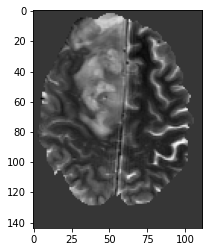

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
t = np.load('train/002_imgs.npy')
print(t.shape)

t = preprocess(t)
plt.imshow(t[2][100], cmap='Greys_r')
print(t.shape)

1.0
(134, 170, 134)


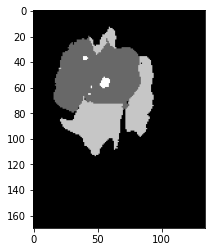

In [ ]:
t = np.load('train/003_seg.npy')
plt.imshow(t[100], cmap='Greys_r')
print(t[100][60][30])
print(t.shape)

False
(3, 112, 144, 112)


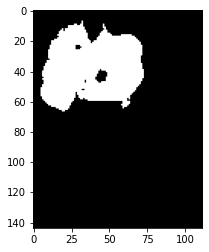

In [ ]:
t = np.load('train/003_seg.npy')
t = preprocess_label(t)
plt.imshow(t[0][89], cmap='Greys_r')
print(t[0][100][60][30])
print(t.shape)

In [ ]:
import glob
imgs = sorted(glob.glob('train/*imgs.npy'))
segs = sorted(glob.glob('train/*seg.npy'))

In [ ]:
data_size = len(imgs)
input_shape = (4, 112, 144, 112)
output_channels = 3
data = np.empty((data_size,) + input_shape, dtype=np.float32)
labels = np.empty((data_size, output_channels) + input_shape[1:])

In [ ]:
# minh = 300
# minw = 300
# mind = 300
# for segname in segs:
#   h,w,d = np.load(segname).shape
#   if h<minh:
#     minh=h
#   if w<minw:
#     minw=w
#   if d<mind:
#     mind=d
# print(minh,minw,mind)

In [ ]:
import math

# Parameters for the progress bar
total = data_size
step = 25 / total

for i, (imgname, segname) in enumerate(zip(imgs,segs)):
    try:
        data[i] = preprocess(np.load(imgname).astype('float32'))
        labels[i] = preprocess_label(np.load(segname))
        
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

Progress: [=========================](100 %)

(112, 144, 112)
0.0


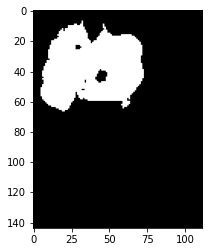

In [ ]:
t = labels[2]
plt.imshow(t[0][89], cmap='Greys_r')
print(t[0].shape)
print(labels[0][0][97][50][50])

In [ ]:
model = build_model(input_shape=input_shape, output_channels=3)

In [ ]:
from keras.models import load_model
model = load_model('440epoch.h5', custom_objects={'loss_gt_': loss_gt(1e-8), 'dice_coefficient': dice_coefficient})

In [ ]:
model.fit(data, labels, batch_size=1, epochs=200)

Epoch 1/200
204/204 [==============================] - 155s 761ms/step - loss: -0.9079 - dice_coefficient: 0.9079
Epoch 2/200
204/204 [==============================] - 155s 762ms/step - loss: -0.9100 - dice_coefficient: 0.9100
Epoch 3/200
204/204 [==============================] - 155s 762ms/step - loss: -0.9076 - dice_coefficient: 0.9076
Epoch 4/200
204/204 [==============================] - 155s 762ms/step - loss: -0.9094 - dice_coefficient: 0.9094
Epoch 5/200
204/204 [==============================] - 156s 762ms/step - loss: -0.9104 - dice_coefficient: 0.9104
Epoch 6/200
204/204 [==============================] - 155s 762ms/step - loss: -0.9090 - dice_coefficient: 0.9090
Epoch 7/200
204/204 [==============================] - 155s 762ms/step - loss: -0.9003 - dice_coefficient: 0.9003
Epoch 8/200
204/204 [==============================] - 155s 762ms/step - loss: -0.8904 - dice_coefficient: 0.8904
Epoch 9/200
204/204 [==============================] - 156s 762ms/step - loss: -0.8930 -

In [ ]:
model.save('440epoch.h5')

In [ ]:
l = model.predict(data[2:3])

1.0
(134, 170, 134)
[0. 1. 2. 3.]


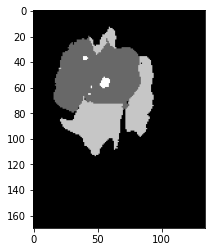

In [ ]:
t = np.load('train/003_seg.npy')
plt.imshow(t[100], cmap='Greys_r')
print(t[100][60][30])
print(t.shape)
print(np.unique(t[100]))

[0. 1. 2. 3.]


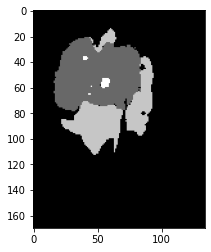

In [ ]:
t = l[0]
t = post_process(t,(134, 170, 134))
plt.imshow(t[100], cmap='Greys_r')
print(np.unique(t[100]))

In [ ]:
vs = np.load('validation/005_seg.npy')

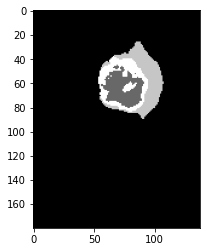

In [ ]:
plt.imshow(vs[100], cmap='Greys_r')

In [ ]:
# 117 145 124
def crop(img, orig_shape):
# centercrop to (112,144,112)
  H,W,D = orig_shape

  center_h = H//2
  center_w = W//2
  center_d = D//2

  y = img[center_h-56:center_h+56,
          center_w-72:center_w+72,
          center_d-56:center_d+56]
  return y
      
def preprocess(img):

  y = np.zeros((4,112,144,112))
  for i in range(4):
    y[i] = crop(img[i], img[i].shape)
  
  # Normalize the image
  mean = y.mean()
  std = y.std()
  return (y - mean) / std

def preprocess_label(img):

  y = crop(img, img.shape)

  ncr = y == 1  # Necrotic and Non-Enhancing Tumor (NCR/NET)
  ed = y == 2  # Peritumoral Edema (ED)
  et = y == 3  # GD-enhancing Tumor (ET)

  return np.array([ncr, ed, et])

In [ ]:
import numpy as np

def combine(result):

  matrix=np.zeros((112,144,112))
  for i in range (112):
    for j in range(144):
        for k in range(112):
            #find the maximum position in 3 channels
            values = np.array([result[0][i][j][k], result[1][i][j][k], result[2][i][j][k]])
            max_ind = np.argmax(values)
            if values[max_ind] >= 0.5:
              matrix[i,j,k]=max_ind+1
            else:
              matrix[i,j,k]=0.0
  
  return matrix

def padding(result, orig_shape):

  H,W,D= orig_shape
  matrix=np.zeros((H,W,D))

  center_h = H//2
  center_w = W//2
  center_d = D//2

  matrix[center_h-56:center_h+56,
         center_w-72:center_w+72,
         center_d-56:center_d+56] = result
  
  return matrix

def post_process(output, orig_shape):
  
  one_c = combine(output)
  one_c = padding(one_c, orig_shape)

  return one_c

(4, 140, 173, 139)
(4, 112, 144, 112)


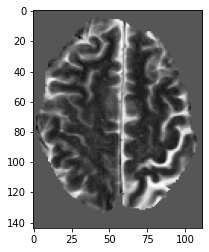

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
t = np.load('test_pub/002_imgs.npy')
print(t.shape)

t = preprocess(t)
plt.imshow(t[2][100], cmap='Greys_r')
print(t.shape)

In [ ]:
import glob
imgs = sorted(glob.glob('test_pub/*imgs.npy'))


In [ ]:
data_size = len(imgs)
input_shape = (4, 112,144,112)
output_channels = 3
data = np.empty((data_size,) + input_shape, dtype=np.float32)
print(data_size)

68


In [ ]:
import math

# Parameters for the progress bar
total = data_size
step = 25 / total

for i, imgname in enumerate(imgs):
    try:
        data[i] = preprocess(np.load(imgname).astype('float32'))
        
        # Print the progress bar
        print('\r' + f'Progress: '
            f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
            f"({math.ceil((i+1) * 100 / (total))} %)",
            end='')
    except Exception as e:
        print(f'Something went wrong with {imgs["t1"]}, skipping...\n Exception:\n{str(e)}')
        continue

Progress: [=========================](100 %)

In [ ]:
model = build_model(input_shape=input_shape, output_channels=3)

In [ ]:
from keras.models import load_model
model = load_model('440epoch.h5', custom_objects={'loss_gt_': loss_gt(1e-8), 'dice_coefficient': dice_coefficient})

In [ ]:
prediction = model.predict(data[0:1])
t = np.load('test_pub/001_imgs.npy')
print(t.shape)
print(t[0].shape)


prediction_1=post_process(prediction[0], t[0].shape)
20,30,40,50,60

SyntaxError: ignored

In [ ]:
prediction=model.predict(data[60:69])
for i in range(9):
  a=np.load("test_pub/{:03d}_imgs.npy".format(i+61))
  predict=post_process(prediction[i], a[0].shape)
  np.save('result1/{:03d}_seg.npy'.format(i+61),predict )

print("done")

FileNotFoundError: ignored

In [ ]:
prediction = model.predict(data[0:1])

for i in range(10):
  np.save('result1/{:03d}_seg.npy'.format(i+1),prediction[i] )

IndexError: ignored

In [ ]:
import os
import numpy as np

from glob import glob
import pandas as pd
from tqdm import tqdm

# example: BraTS20_Training_010_imgs.npy

data_dir = 'result1' #None # path to data/npy folder

# from: https://gist.github.com/nvictus/66627b580c13068589957d6ab0919e66
def rlencode(x, dropna=False):
  """
  Run length encoding.
  Based on http://stackoverflow.com/a/32681075, which is based on the rle 
  function from R.
  
  Parameters
  ----------
  x : 1D array_like
      Input array to encode
  dropna: bool, optional
      Drop all runs of NaNs.
  
  Returns
  -------
  start positions, run lengths, run values
  
  """
  where = np.flatnonzero
  x = np.asarray(x)
  n = len(x)
  if n == 0:
              return (np.array([], dtype=int), 
                      np.array([], dtype=int), 
                      np.array([], dtype=x.dtype))

  starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
  lengths = np.diff(np.r_[starts, n])
  values = x[starts]
  
  if dropna:
      mask = ~np.isnan(values)
      starts, lengths, values = starts[mask], lengths[mask], values[mask]
  
  return starts, lengths, values



files = glob('{}/*'.format(data_dir))

ids = []
codes = []

for i, file in enumerate(tqdm(files)):
    if not file.split('/')[-1][4:4+3] == 'seg':
        continue

    im_name = file.split('/')[-1][:3]
    sample = np.load(file).flatten()
    
    starts, lengths, values = rlencode(sample)
    code_1 = ''
    code_2 = ''
    code_3 = ''
    code_4 = ''
    for start, length, value in zip(starts, lengths, values):
        if value == 0:
            code_1 += '{} {} '.format(start, length)
        elif value == 1:
            code_2 += '{} {} '.format(start, length)
        elif value == 2:
            code_3 += '{} {} '.format(start, length)
        elif value == 3:
            code_4 += '{} {} '.format(start, length)

    # update final output list
    for i in range(4):
        id = '{}_{}'.format(im_name, i)
        ids.append(id)
    codes.extend([code_1.strip(), code_2.strip(), code_3.strip(), code_4.strip()])


dic = {'Id': ids, 'Expected': codes}
df = pd.DataFrame(dic)
df.to_csv('solution_val.csv', index=False)

100%|██████████| 68/68 [00:22<00:00,  3.04it/s]


In [ ]:
import os
import argparse
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

# from: https://gist.github.com/nvictus/66627b580c13068589957d6ab0919e66
def rlencode(x, dropna=False):
    """
    Run length encoding.
    Based on http://stackoverflow.com/a/32681075, which is based on the rle 
    function from R.
    
    Parameters
    ----------
    x : 1D array_like
        Input array to encode
    dropna: bool, optional
        Drop all runs of NaNs.
    
    Returns
    -------
    start positions, run lengths, run values
    
    """
    where = np.flatnonzero
    x = np.asarray(x)
    n = len(x)
    if n == 0:
                return (np.array([], dtype=int), 
                        np.array([], dtype=int), 
                        np.array([], dtype=x.dtype))

    starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, n])
    values = x[starts]
    
    if dropna:
        mask = ~np.isnan(values)
        starts, lengths, values = starts[mask], lengths[mask], values[mask]
    
    return starts, lengths, values


    # get all the npy files in folder
files = glob('{}/*'.format("result1"))


ids = []    # ImageId_ClassId columns
codes = []  # EncodedPixels columns

# iterate through the entire folders. Compute the run-length encoding for each segmenation npy file
for i, file in enumerate(tqdm(files)):
    # check if the file is seg (exclude img npy file)
    # npy file name are expected to have the format of XXX_seg.npy
    if not file.split('/')[-1][-7:-4] == 'seg':
        continue

    # im_name are expected to have the format of XXX_seg.npy
    im_name = file.split('/')[-1][:3]
    sample = np.load(file).flatten() # flatten the numpy array to 1d
    
    # get the start position, 
    # length for each segment correspoding to start position, 
    # and the value/labels for each segments
    starts, lengths, values = rlencode(sample)

    # these will be the encoded pixels strings for each image, 4 labels for each iamge
    code_1 = ''
    code_2 = ''
    code_3 = ''
    code_4 = ''
    # convert the run-length encoding output from rlencode function to the required csv format
    for start, length, value in zip(starts, lengths, values):
        if value == 0:
            code_1 += '{} {} '.format(start, length)
        elif value == 1:
            code_2 += '{} {} '.format(start, length)
        elif value == 2:
            code_3 += '{} {} '.format(start, length)
        elif value == 3:
            code_4 += '{} {} '.format(start, length)

    # update final output list, add for rows for each image (4 labels)
    for i in range(4):
        id = '{}_{}'.format(im_name, i)
        ids.append(id)
    codes.extend([code_1.strip(), code_2.strip(), code_3.strip(), code_4.strip()])


dic = {'ImageId_ClassId': ids, 'EncodedPixels': codes}
df = pd.DataFrame(dic)
df.to_csv("solution_val1.csv", index=False)



# This is a sample script for outputing a run-legnth encoding csv file, which is required for kaggle to work
# Assume all predicted segmentation in npy format are stored in a folder
# this script output the run-length encoding csv file to the specified location

# Example output:

# ClassId_,Expected
# dummy1_0,0 1 2 2 6 2
# dummy1_1,1 1 4 2
# dummy2_0,2 2 5 1
# dummy2_1,0 2 4 1 6 2

# two dummy image each with label 0 and 1, whice gives us a total of 4 rows


# example command to use this scrip:
# python create_submission.py --seg-dir validation --out-csv-path temp.csv
# validation is the folder to your seg files, temp.csv is the output csv file

100%|██████████| 68/68 [00:03<00:00, 18.19it/s]
